<a href="https://colab.research.google.com/github/hnidey13/tesis_SVD_t-SVDM/blob/main/Copia_de_TensorFMRI_MNISTNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google drive

# https://medium.com/@ashwindesilva/how-to-use-google-colaboratory-to-clone-a-github-repository-e07cf8d3d22b
# https://stackoverflow.com/questions/48350226/methods-for-using-git-with-google-colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
# clone the repository one time into your Google Drive
#os.chdir('/content/gdrive/MyDrive/')

# try this first
#!git clone https://github.com/hnidey13/tensor-fmri.git

# if the above does not clone the repo, you will have to create a personal access token
# !git clone https://<personal access token>@github.com/<username>/tensor-fmri.git

os.chdir('/content/gdrive/MyDrive/tensor-fmri')
#!git pull


Mounted at /content/gdrive


Some prelimary code to visualize tensor-tensor products, the t-SVD, and projections.


In [ ]:
# import modules
import numpy as np
from data.mnist import load_tensor, init
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm

#init()  # download mnist data (only do this once); will be stored in tensor-fmri directory; takes some time to download

Download complete.
Save complete.


Choose an available tensor-tensor product.  Options for this notebook include:

* 'f' : facewise product (no transform along third dimension)
* 't' : t-product (fast Fourier transform along third dimension)
* 'c': c-product (discrete cosine transform along third dimension)


In [ ]:
# choose product type {'f', 't', 'c'}
prod_type = 'f'

Given a tensor-tensor product $\star_M$, the projection of a tensor $\mathcal{A}$
onto the space spanned by the lateral slices of a tensor $\mathcal{U}$ is

$$\mathcal{U} \star_M \mathcal{U}^\top \star_M \mathcal{A}$$

In [ ]:
def projection(A, U, prod_type):
    training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
    return tp.ten_prod(U, training_coeff, prod_type=prod_type)

The [MNIST Dataset](http://yann.lecun.com/exdb/mnist/) is a set of handwritten digits from $0$ to $9$.
These are $28\times 28$ grayscale images and historically have been the starting point for
most image classification tasks.

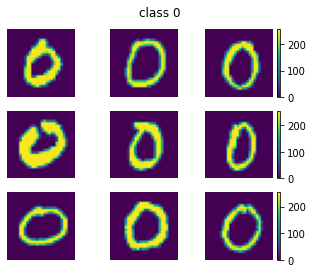

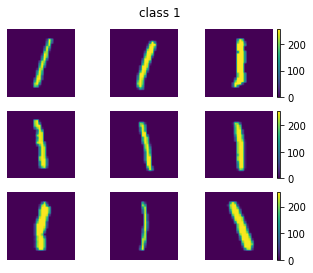

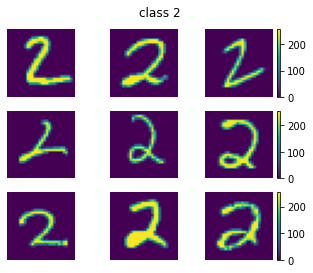

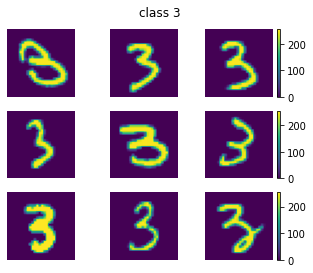

(28, 36, 28)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [ ]:
# for reproducibility
np.random.seed(20)

# load data
num_classes = 4
training_data, training_labels, test_data, test_labels = load_tensor(num_per_class_train=100, num_per_class_test=9,
                                                                     num_classes=num_classes, path='')

# permute such that lateral slices are the images
training_data = training_data.transpose(0, 2, 1)
test_data = test_data.transpose(0, 2, 1)

# visualize data
for i in range(num_classes):
    slice_subplots(test_data[:, test_labels == i, :], axis=1, title='class ' + str(i))
    plt.show()

print(test_data.shape)
print(test_labels)

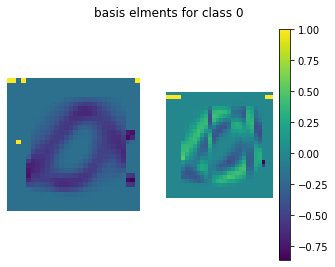

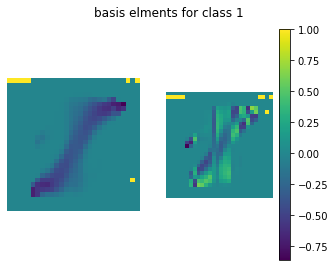

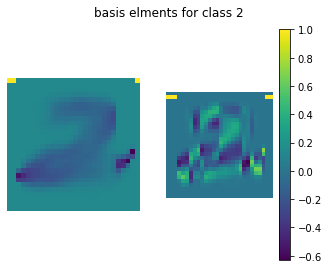

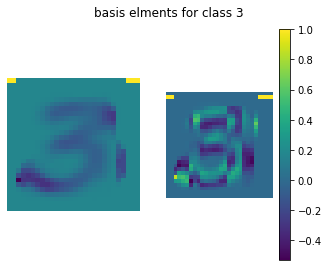

In [ ]:
# form local t-svd
num_classes = len(np.unique(training_labels))
k = 2

U = []
for i in range(num_classes):
    u, _, _, _ = tp.ten_svd(training_data[:, training_labels == i, :], k, prod_type=prod_type)
    U.append(u)

# visualizations
for i in range(num_classes):
    slice_subplots(U[i], axis=1, title='basis elments for class ' + str(i))
    plt.show()


train accuracy = 95.50
test accuracy = 94.44


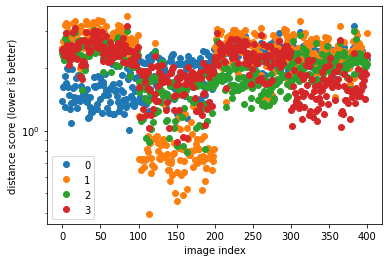

In [ ]:
# compute results on training and test data
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# results
training_num_correct = np.sum(training_predicted_classes == training_labels)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == test_labels)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

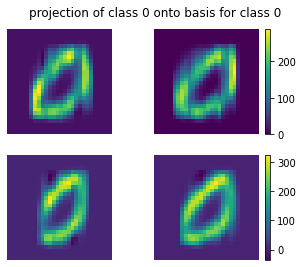

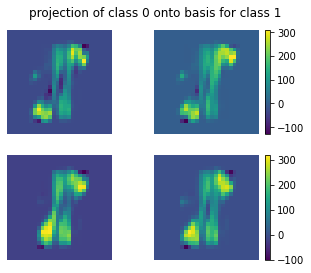

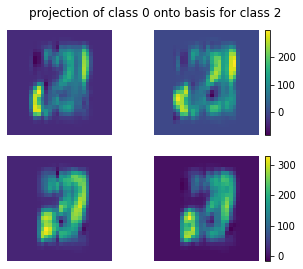

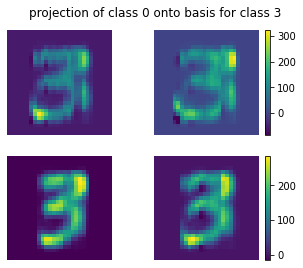

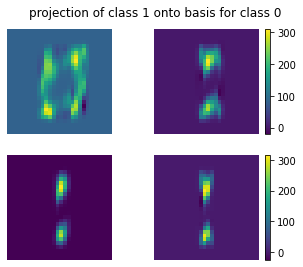

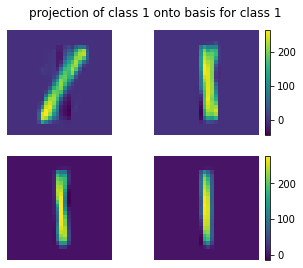

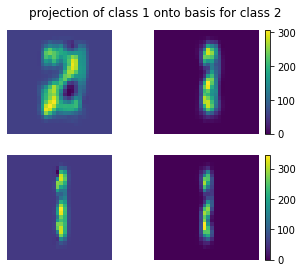

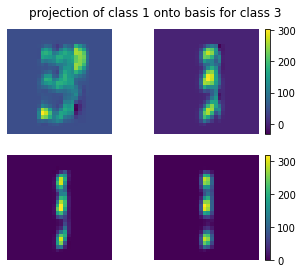

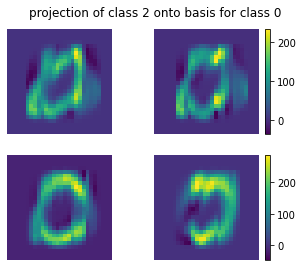

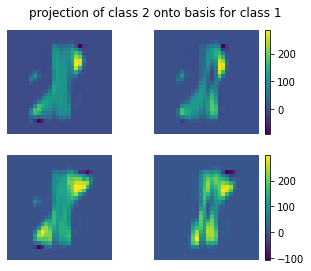

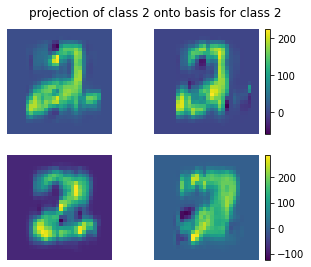

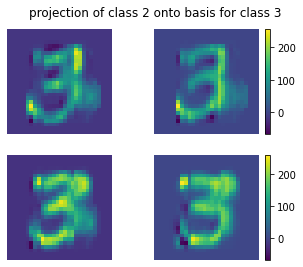

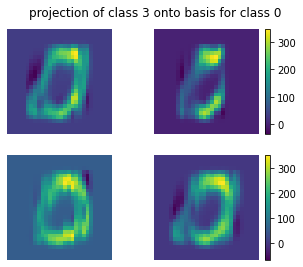

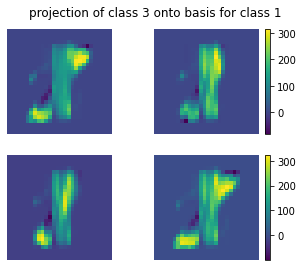

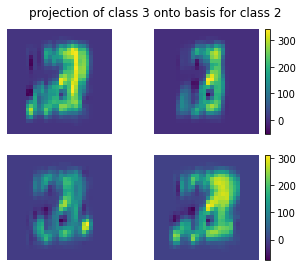

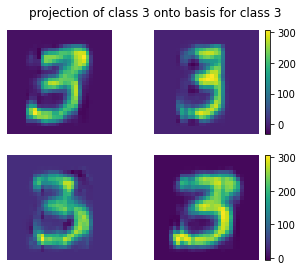

In [ ]:
# visualizations of projected tensors
for j in range(num_classes):
    for i in range(num_classes):
        A = projection(training_data[:, training_labels == j, :], U[i], prod_type=prod_type)
        slice_subplots(A[:, :4, :], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()
